In [189]:
import cartoframes
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

In [3]:
cc = cartoframes.CartoContext()

# Write lion lines dataset to CARTO

In [524]:
lines = gpd.read_file('lion_lines.geojson')

In [526]:
cc.write(lines, 'lion_lines_full', overwrite=True, encode_geom=True)

/anaconda3/lib/python3.6/site-packages/carto/resources.py:90: FutureWarning: This is part of a non-public CARTO API and may change in the future. Take this into account if you are using this in a production environment
  warnings.warn('This is part of a non-public CARTO API and may change in the future. Take this into account if you are using this in a production environment', FutureWarning)


The following columns were changed in the CARTO copy of this dataframe:
OBJECTID -> objectid
Street -> street
SAFStreetName -> safstreetname
FeatureTyp -> featuretyp
SegmentTyp -> segmenttyp
IncExFlag -> incexflag
RB_Layer -> rb_layer
NonPed -> nonped
TrafDir -> trafdir
TrafSrc -> trafsrc
SpecAddr -> specaddr
FaceCode -> facecode
SeqNum -> seqnum
StreetCode -> streetcode
SAFStreetCode -> safstreetcode
LGC1 -> lgc1
LGC2 -> lgc2
LGC3 -> lgc3
LGC4 -> lgc4
LGC5 -> lgc5
LGC6 -> lgc6
LGC7 -> lgc7
LGC8 -> lgc8
LGC9 -> lgc9
BOE_LGC -> boe_lgc
SegmentID -> segmentid
SegCount -> segcount
LocStatus -> locstatus
LZip -> lzip
RZip -> rzip
LBoro -> lboro
RBoro -> rboro
L_CD -> l_cd
R_CD -> r_cd
LATOMICPOLYGON -> latomicpolygon
RATOMICPOLYGON -> ratomicpolygon
LCT2010 -> lct2010
LCT2010Suf -> lct2010suf
RCT2010 -> rct2010
RCT2010Suf -> rct2010suf
LCB2010 -> lcb2010
LCB2010Suf -> lcb2010suf
RCB2010 -> rcb2010
RCB2010Suf -> rcb2010suf
LCT2000 -> lct2000
LCT2000Suf -> lct2000suf
RCT2000 -> rct2000
RCT20

# Simple buffer method

In [19]:
query = '''
SELECT 
  line.cartodb_id, 
  line.the_geom, 
  line.the_geom_webmercator, 
  COUNT(circle.the_geom) as count_collisions, 
  SUM(circle.number_of_persons_killed) as sum_fatalities
FROM lion_lines_nyc AS line 
JOIN nypd_collisions_2017 AS circle 
ON ST_DWithin(
  line.the_geom_webmercator, 
  circle.the_geom_webmercator, 
  30
  )
GROUP BY 
  line.cartodb_id, 
  line.the_geom, 
  line.the_geom_webmercator 
'''

In [20]:
counts = cc.query(query, table_name = 'crash_count_segment')

Table successfully written to CARTO: https://michellemho-carto.carto.com/dataset/crash_count_segment


In [30]:
counts.reset_index(inplace=True)
road_segments = cc.read('lion_lines_full', decode_geom=True)
road_segments.reset_index(inplace=True)
road_collision_count = road_segments.join(counts, on='cartodb_id', how='left', lsuffix='_left')
road_collision_count.shape

In [53]:
# Fill NAs with zeros (zero crashes)
road_collision_count.count_collisions.fillna(value=0, inplace=True)
road_collision_count.sum_fatalities.fillna(value=0, inplace=True)

In [463]:
collisions = cc.read('nypd_collisions_2017')

In [464]:
collisions.columns

Index(['borough', 'contributing_factor_vehicle_1',
       'contributing_factor_vehicle_2', 'contributing_factor_vehicle_3',
       'contributing_factor_vehicle_4', 'contributing_factor_vehicle_5',
       'cross_street_name', 'date', 'latitude', 'location', 'longitude',
       'number_of_cyclist_injured', 'number_of_cyclist_killed',
       'number_of_motorist_injured', 'number_of_motorist_killed',
       'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
       'number_of_persons_injured', 'number_of_persons_killed',
       'off_street_name', 'on_street_name', 'the_geom', 'time', 'unique_key',
       'vehicle_type_code_1', 'vehicle_type_code_2', 'vehicle_type_code_3',
       'vehicle_type_code_4', 'vehicle_type_code_5', 'zip_code'],
      dtype='object')

In [468]:
collisions.shape

(229348, 30)

# Better method for finding nearest segment

In [23]:
find_nearest_query = '''
SELECT
  roads.cartodb_id as cartodb_id,
  count(collisions.cartodb_id) as collision_count,
  sum(collisions.number_of_persons_injured) as sum_injuries,
  sum(collisions.number_of_persons_killed) as sum_fatalities,
  sum(collisions.number_of_cyclist_injured) as sum_cyclist_injured,
  sum(collisions.number_of_cyclist_killed) as sum_cyclist_killed,
  sum(collisions.number_of_motorist_injured) as sum_motorists_injured,
  sum(collisions.number_of_motorist_killed) as sum_motorists_killed,
  sum(collisions.number_of_pedestrians_injured) as sum_pedestrian_injured,
  sum(collisions.number_of_pedestrians_killed) as sum_pedestrian_killed 
FROM
  (SELECT cartodb_id, the_geom, the_geom_webmercator, number_of_cyclist_injured,
        number_of_cyclist_killed,
        number_of_motorist_injured,
        number_of_motorist_killed,
        number_of_pedestrians_injured,
        number_of_pedestrians_killed,
        number_of_persons_injured,
        number_of_persons_killed
   FROM nypd_collisions_2017) AS collisions
CROSS JOIN LATERAL
  (SELECT cartodb_id, the_geom, the_geom_webmercator
   FROM lion_lines_full as roads
   ORDER BY collisions.the_geom_webmercator <-> the_geom_webmercator
   LIMIT 1) AS roads
GROUP BY roads.cartodb_id
'''

In [528]:
nearest_road = cc.query(find_nearest_query)

In [529]:
nearest_road.shape

(49252, 9)

In [531]:
nearest_road.head()

,collision_count,sum_cyclist_injured,sum_cyclist_killed,sum_fatalities,sum_injuries,sum_motorists_injured,sum_motorists_killed,sum_pedestrian_injured,sum_pedestrian_killed
cartodb_id,,,,,,,,,
11890,3,0,0,0,2,2,0,0,0
2848,2,0,0,0,0,0,0,0,0
47486,7,0,0,0,0,0,0,0,0
122515,3,0,0,0,1,1,0,0,0
49009,1,0,0,0,1,1,0,0,0


In [534]:
road_segments.reset_index(inplace=True)

In [535]:
collision_join = road_segments.join(nearest_road, on='cartodb_id', how='left', lsuffix='_left')

In [536]:
collision_join.shape

(226420, 131)

In [537]:
collision_join.collision_count.fillna(value=0, inplace=True)
collision_join.sum_injuries.fillna(value=0, inplace=True)
collision_join.sum_fatalities.fillna(value=0, inplace=True)
collision_join.sum_cyclist_injured.fillna(value=0, inplace=True)
collision_join.sum_cyclist_killed.fillna(value=0, inplace=True)
collision_join.sum_motorists_injured.fillna(value=0, inplace=True)
collision_join.sum_motorists_killed.fillna(value=0, inplace=True)
collision_join.sum_pedestrian_injured.fillna(value=0, inplace=True)
collision_join.sum_pedestrian_killed.fillna(value=0, inplace=True)

# Check that there's no double counting

In [538]:
# matches the number of rows in the nypd collision dataset
collision_join.collision_count.sum()

229348.0

In [539]:
# double counting here
road_collision_count.count_collisions.sum()

899253.0

In [540]:
collision_join.drop(['the_geom','cartodb_id'], axis=1, inplace=True, errors='ignore')

In [541]:
collision_join.head()

,active_flag,arccenterx,arccentery,bike_trafdir,bikelane,boe_lgc,borobndry,carto_display_level,conparity,curveflag,...,geometry,collision_count,sum_cyclist_injured,sum_cyclist_killed,sum_fatalities,sum_injuries,sum_motorists_injured,sum_motorists_killed,sum_pedestrian_injured,sum_pedestrian_killed
0,,0,0,,,1,,,,,...,(LINESTRING (-73.86782066461737 40.85850315020...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,,0,0,,,1,,,,I,...,(LINESTRING (-73.86807379955592 40.88189253260...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,,0,0,TW,1,1,,,,,...,(LINESTRING (-73.92718050670962 40.84638847550...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,,0,0,,,1,,,,,...,(LINESTRING (-73.8650518019418 40.669292904954...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,,0,0,,,1,L,,,,...,(LINESTRING (-73.94371184877399 40.56514113185...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [502]:
import geopandas as gpd

In [544]:
collision_join.to_csv('collision_join')

In [543]:
cc.write(collision_join, 'collision_join', overwrite=True, encode_geom=True)

/anaconda3/lib/python3.6/site-packages/cartoframes/context.py:1816: UserWarning: `encode_geom` works best with Geopandas (http://geopandas.org/) and/or shapely (https://pypi.python.org/pypi/Shapely).
/anaconda3/lib/python3.6/site-packages/carto/resources.py:90: FutureWarning: This is part of a non-public CARTO API and may change in the future. Take this into account if you are using this in a production environment
  warnings.warn('This is part of a non-public CARTO API and may change in the future. Take this into account if you are using this in a production environment', FutureWarning)


CartoException: Error code: `99999`. See CARTO Import API error documentation for more information: https://carto.com/docs/carto-engine/import-api/import-errors

In [555]:
len(collision_join.columns)

129

## Data Cleaning

In [4]:
collision_join = pd.read_csv('collision_join.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1,14,20,29,38,46,47,67,78,85,86,90,104) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [231]:
lion_lines = cc.read('lion_lines_full', decode_geom=True)

In [286]:
data = lion_lines[['featuretyp','bikelane','bike_trafdir','nonped',
                    'number_park_lanes','number_total_lanes','number_travel_lanes', 'posted_speed',
                    'snow_priority','streetwidth_max','trafdir','shape_length', 'geometry', 'streetcode',
                  'nodeidfrom','nodeidto']]

In [287]:
data.dtypes

featuretyp              object
bikelane                object
bike_trafdir            object
nonped                  object
number_park_lanes       object
number_total_lanes      object
number_travel_lanes     object
posted_speed            object
snow_priority           object
streetwidth_max          int64
trafdir                 object
shape_length           float64
geometry                object
streetcode              object
nodeidfrom              object
nodeidto                object
dtype: object

In [288]:
data.featuretyp.unique()

array(['0', '3', '2', 'A', '8', '6', '9', '7', '1', 'W', '5', 'F', 'C'],
      dtype=object)

In [289]:
# Remove non-vehicle roads
nonvehicle_roads = ['3','1','2','5','7','8','9','W','F']
data_vehicles = data[~data['featuretyp'].isin(nonvehicle_roads)]

In [290]:
# Change posted speed to numeric
posted_speeds = ['25', '  ', '50', '20', '40', '30', '35', '45', '15']
numeric_speeds = [25, None, 50, 20, 40, 30, 35, 45, 15]
data_vehicles.posted_speed.replace(to_replace=posted_speeds, value=numeric_speeds, inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [291]:
# change number_park_lanes, number_total_lanes, number_travel_lanes to numeric
park_lanes = data_vehicles.number_park_lanes.unique()
new_park_lanes = [None, 2, 1, 4]
total_lanes = data_vehicles.number_total_lanes.unique()
new_total_lanes = [1, None, 3, 2, 4, 6, 8, 7, 5, 9, 16, 12, 10]
number_travel_lanes = data_vehicles.number_travel_lanes.unique()
new_travel_lanes = [1, None, 2, 4, 3, 6, 5, 8, 16, 7, 12, 10, 9]

data_vehicles.number_park_lanes.replace(to_replace=park_lanes, value=new_park_lanes, inplace=True)
data_vehicles.number_total_lanes.replace(to_replace=total_lanes, value=new_total_lanes, inplace=True)
data_vehicles.number_travel_lanes.replace(to_replace=number_travel_lanes, value=new_travel_lanes, inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [292]:
# fix travel or parking lanes to 0 if there are total lanes
# condition if number_park_lanes is NaN
condition = (~data_vehicles['number_total_lanes'].isna() & data_vehicles['number_park_lanes'].isna())
data_vehicles.loc[condition, 'number_park_lanes'] = 0

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [293]:
# Only two odd cases where total_lanes != number_park_lanes + number_travel_lanes
data_vehicles[(~data_vehicles['number_total_lanes'].isna())][data_vehicles['number_travel_lanes']+data_vehicles['number_park_lanes']!=data_vehicles['number_total_lanes']]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,featuretyp,bikelane,bike_trafdir,nonped,number_park_lanes,number_total_lanes,number_travel_lanes,posted_speed,snow_priority,streetwidth_max,trafdir,shape_length,geometry,streetcode,nodeidfrom,nodeidto
cartodb_id,,,,,,,,,,,,,,,,
79006,0,,,,0.0,4.0,2.0,NaN,C,0,T,38.230866,(LINESTRING (-73.99741626994901 40.67034861505...,346920,0014633,9047687
79007,0,,,,0.0,4.0,2.0,NaN,C,0,T,25.891977,(LINESTRING (-73.99753325511467 40.67029314239...,346920,9047687,9047689


In [294]:
# add in no-bike lane
data_vehicles.bikelane.replace(to_replace='  ', value='No Bike Lane', inplace=True)
data_vehicles.bike_trafdir.replace(to_replace='  ', value='No bike_trafdir', inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [295]:
# add in pedestrian-friendly nonped category
data_vehicles.nonped.replace(to_replace=' ', value='ped', inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [296]:
# fix snow priority with NA category
data_vehicles.snow_priority.replace(to_replace=' ', value='no_priority', inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [297]:
# Check how many NA rows are dropped... not too bad!
data_vehicles.dropna().shape

(145338, 16)

In [298]:
data_vehicles.shape

(190035, 16)

In [299]:
data_clean = data_vehicles.dropna()

In [300]:
data_clean.columns

Index(['featuretyp', 'bikelane', 'bike_trafdir', 'nonped', 'number_park_lanes',
       'number_total_lanes', 'number_travel_lanes', 'posted_speed',
       'snow_priority', 'streetwidth_max', 'trafdir', 'shape_length',
       'geometry', 'streetcode', 'nodeidfrom', 'nodeidto'],
      dtype='object')

In [301]:
# Actually, now we should re-do the collision count nearest query...

# Re-do Nearest Query to join cleaned LION lines dataset to collisions

In [302]:
cc.write(data_clean, 'lion_clean', overwrite=True, )

Table successfully written to CARTO: https://michellemho-carto.carto.com/dataset/lion_clean


In [ ]:
# Also, we should remove the null geometry rows from the collision dataset...

In [155]:
cc.query('select count(*) from nypd_collisions_2017 where the_geom is null')

,count
0,16524


In [156]:
cc.query('select count(*) from nypd_collisions_2017 where the_geom is not null')

,count
0,212824


In [159]:
cc.query('SELECT * from nypd_collisions_2017 where the_geom is not null', table_name='collisions_geom')

Table successfully written to CARTO: https://michellemho-carto.carto.com/dataset/collisions_geom


,borough,contributing_factor_vehicle_1,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,cross_street_name,date,latitude,location,...,on_street_name,the_geom,time,unique_key,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,zip_code
cartodb_id,,,,,,,,,,,,,,,,,,,,,
8084,,Unspecified,,,,,,2017-03-31,40.673588,"(40.673588, -73.96296)",...,SAINT JOHNS PLACE,0101000020E6100000CBD6FA22A17D52C0317DAF213856...,2018-06-28 21:15:00,3643833,PASSENGER VEHICLE,,,,,NaN
3,,Fell Asleep,,,,,,2017-03-20,40.738495,"(40.738495, -73.90274)",...,,0101000020E6100000A032FE7DC67952C038A11001875E...,2018-06-28 05:30:00,3635097,PASSENGER VEHICLE,,,,,NaN
322,BROOKLYN,Unspecified,,,,,7 AVENUE,2017-03-20,40.658134,"(40.658134, -73.9896)",...,22 STREET,0101000020E6100000C8073D9B557F52C05D3123BC3D54...,2018-06-28 13:15:00,3635919,PASSENGER VEHICLE,,,,,11215.0
405,,Following Too Closely,Unspecified,,,,,2017-02-14,40.667800,"(40.6678, -73.801414)",...,,0101000020E61000009E23F25D4A7352C068226C787A55...,2018-06-28 07:30:00,3616606,PASSENGER VEHICLE,PASSENGER VEHICLE,,,,NaN
542,MANHATTAN,Unspecified,Unspecified,,,,RIVERSIDE DRIVE,2017-03-20,40.792720,"(40.79272, -73.9771)",...,WEST 91 STREET,0101000020E6100000FB3A70CE887E52C04C7155D97765...,2018-06-28 14:00:00,3636189,PASSENGER VEHICLE,,,,,10024.0
711,MANHATTAN,Unspecified,,,,,EAST 76 STREET,2017-03-20,40.774370,"(40.77437, -73.963554)",...,MADISON AVENUE,0101000020E6100000857B65DEAA7D52C07380608E1E63...,2018-06-28 12:30:00,3636806,,,,,,10021.0
877,,Unspecified,Unspecified,,,,,2017-03-31,40.695790,"(40.69579, -73.967804)",...,,0101000020E6100000083C3080F07D52C022718FA50F59...,2018-06-28 10:24:00,3642456,,,,,,NaN
881,BROOKLYN,Unspecified,,,,,,2017-03-20,40.679962,"(40.679962, -73.91117)",...,,0101000020E61000002AC6F99B507A52C0EA42ACFE0857...,2018-06-28 14:30:00,3637313,PASSENGER VEHICLE,,,,,11233.0
1223,QUEENS,Unspecified,,,,,25 STREET,2017-03-21,40.740932,"(40.740932, -73.94485)",...,50 AVENUE,0101000020E61000000A68226C787C52C0AA471ADCD65E...,2018-06-28 13:45:00,3636626,PASSENGER VEHICLE,,,,,11101.0


In [304]:
find_nearest_query = '''
SELECT
  roads.cartodb_id as cartodb_id,
  count(collisions.cartodb_id) as collision_count,
  sum(collisions.number_of_persons_injured) as sum_injuries,
  sum(collisions.number_of_persons_killed) as sum_fatalities,
  sum(collisions.number_of_cyclist_injured) as sum_cyclist_injured,
  sum(collisions.number_of_cyclist_killed) as sum_cyclist_killed,
  sum(collisions.number_of_motorist_injured) as sum_motorists_injured,
  sum(collisions.number_of_motorist_killed) as sum_motorists_killed,
  sum(collisions.number_of_pedestrians_injured) as sum_pedestrian_injured,
  sum(collisions.number_of_pedestrians_killed) as sum_pedestrian_killed 
FROM
  (SELECT cartodb_id, the_geom, the_geom_webmercator, number_of_cyclist_injured,
        number_of_cyclist_killed,
        number_of_motorist_injured,
        number_of_motorist_killed,
        number_of_pedestrians_injured,
        number_of_pedestrians_killed,
        number_of_persons_injured,
        number_of_persons_killed
   FROM collisions_geom) AS collisions
CROSS JOIN LATERAL
  (SELECT cartodb_id, the_geom, the_geom_webmercator
   FROM lion_clean as roads
   ORDER BY collisions.the_geom_webmercator <-> the_geom_webmercator
   LIMIT 1) AS roads
GROUP BY roads.cartodb_id
'''

nearest_road = cc.query(find_nearest_query)

In [305]:
road_segments = cc.read('lion_clean', decode_geom=True)
road_segments.reset_index(inplace=True)
collision_join = road_segments.join(nearest_road, on='cartodb_id', how='left', lsuffix='_left')
collision_join.shape

(145338, 27)

In [306]:
collision_join.collision_count.fillna(value=0, inplace=True)
collision_join.sum_injuries.fillna(value=0, inplace=True)
collision_join.sum_fatalities.fillna(value=0, inplace=True)
collision_join.sum_cyclist_injured.fillna(value=0, inplace=True)
collision_join.sum_cyclist_killed.fillna(value=0, inplace=True)
collision_join.sum_motorists_injured.fillna(value=0, inplace=True)
collision_join.sum_motorists_killed.fillna(value=0, inplace=True)
collision_join.sum_pedestrian_injured.fillna(value=0, inplace=True)
collision_join.sum_pedestrian_killed.fillna(value=0, inplace=True)

In [307]:
# matches the number of rows in the nypd collision dataset
collision_join.collision_count.sum()

212824.0

In [308]:
collision_join.drop(['the_geom','cartodb_id'], axis=1, inplace=True, errors='ignore')

In [309]:
cc.write(collision_join, 'collision_join_geom', overwrite=True, encode_geom=True)

/Users/mho/proj/cartoframes/cartoframes/context.py:1854: UserWarning: `encode_geom` works best with Geopandas (http://geopandas.org/) and/or shapely (https://pypi.python.org/pypi/Shapely).
  warn('`encode_geom` works best with Geopandas '


Table successfully written to CARTO: https://michellemho-carto.carto.com/dataset/collision_join_geom


# Data Modeling

In [310]:
y = collision_join['collision_count']/collision_join['shape_length']

In [311]:
collision_join.columns

Index(['bike_trafdir', 'bikelane', 'featuretyp', 'nodeidfrom', 'nodeidto',
       'nonped', 'number_park_lanes', 'number_total_lanes',
       'number_travel_lanes', 'posted_speed', 'shape_length', 'snow_priority',
       'streetcode', 'streetwidth_max', 'trafdir', 'geometry',
       'collision_count', 'sum_cyclist_injured', 'sum_cyclist_killed',
       'sum_fatalities', 'sum_injuries', 'sum_motorists_injured',
       'sum_motorists_killed', 'sum_pedestrian_injured',
       'sum_pedestrian_killed'],
      dtype='object')

In [312]:
x = collision_join[['bike_trafdir', 'bikelane', 'featuretyp', 'nonped', 'number_park_lanes',
       'number_total_lanes', 'number_travel_lanes', 'posted_speed',
       'snow_priority', 'streetwidth_max', 'trafdir']]

In [313]:
x.dtypes

bike_trafdir           object
bikelane               object
featuretyp             object
nonped                 object
number_park_lanes       int64
number_total_lanes      int64
number_travel_lanes     int64
posted_speed            int64
snow_priority          object
streetwidth_max         int64
trafdir                object
dtype: object

In [314]:
y.describe()

count    145338.000000
mean          0.011287
std           0.073694
min           0.000000
25%           0.000000
50%           0.000000
75%           0.003856
max           4.198430
dtype: float64

In [315]:
# remove outlier (what happened with null geometries!)

# idx = (collision_join['collision_count']/collision_join['shape_length']).idxmax()
# data = collision_join.drop(idx)

In [316]:
# Add in density measurement
data = collision_join
data['density'] = data['collision_count']/data['shape_length']
y = data['density']
x = data[['bike_trafdir', 'featuretyp', 'nonped', 'number_park_lanes',
       'number_travel_lanes', 'posted_speed',
       'snow_priority', 'streetwidth_max', 'trafdir']]

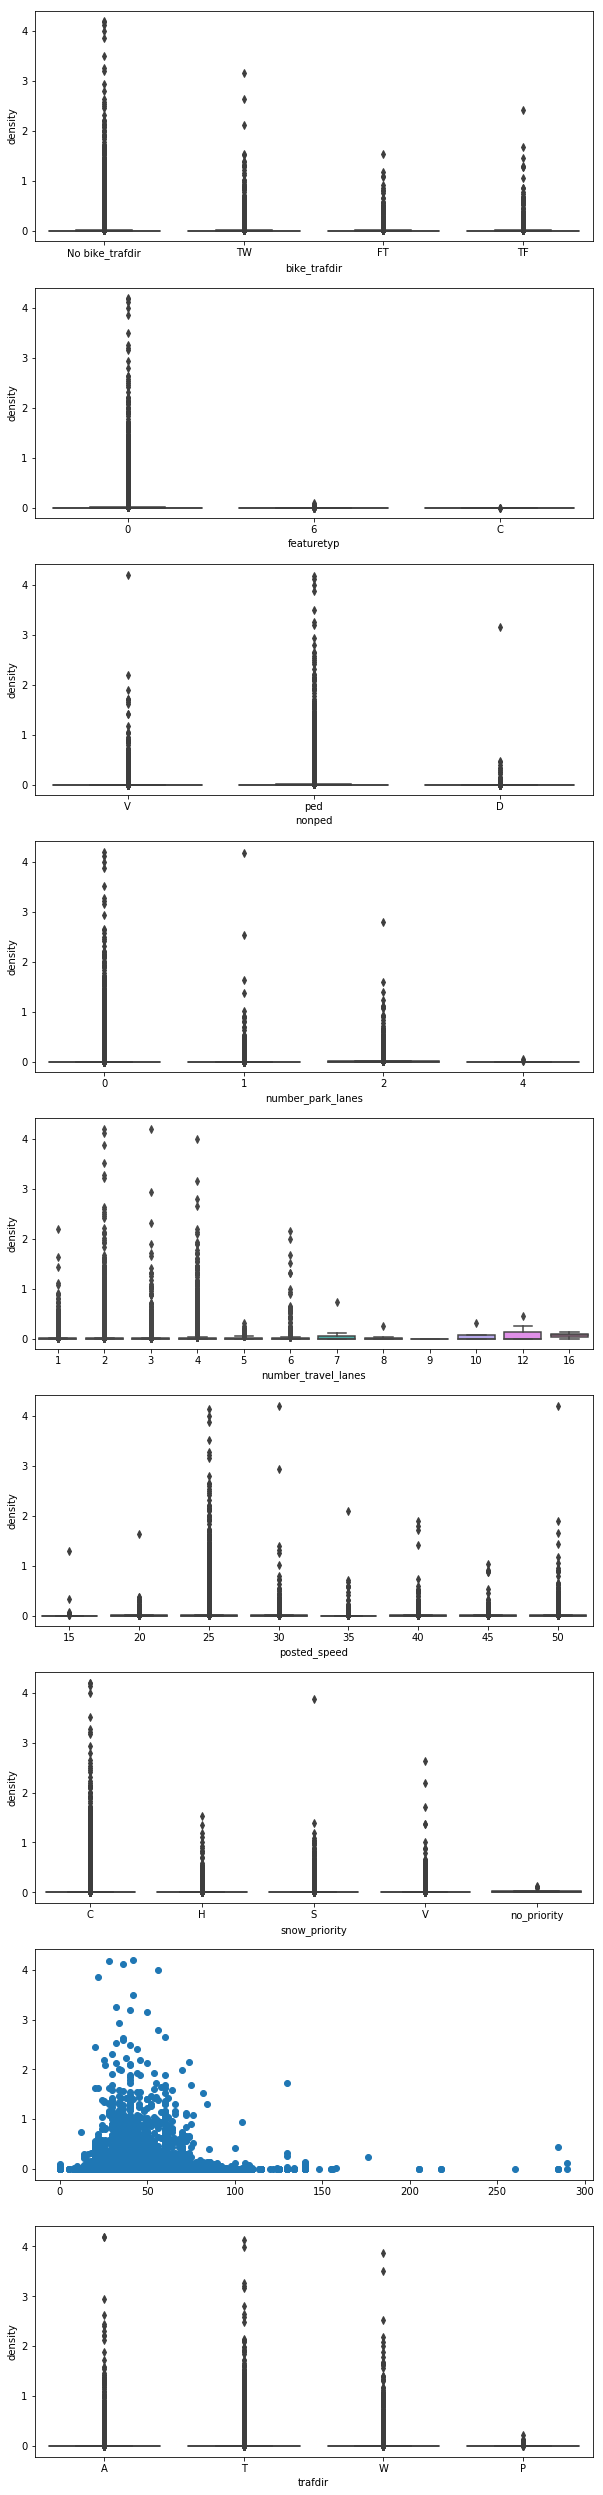

In [317]:
fig, axes = plt.subplots(nrows=len(x.columns), figsize=(10, 5*len(x.columns)))

for i, explan_var in enumerate(x.columns):
    if explan_var != 'streetwidth_max':
        seaborn.boxplot(x=explan_var, y="density", data=data, ax=axes[i])
    else:
        axes[i].scatter(data['streetwidth_max'], data['density'])


(array([1.44769e+05, 4.86000e+02, 6.00000e+01, 1.50000e+01, 4.00000e+00,
        2.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  0. ,  30.1,  60.2,  90.3, 120.4, 150.5, 180.6, 210.7, 240.8,
        270.9, 301. ]),
 <a list of 10 Patch objects>)

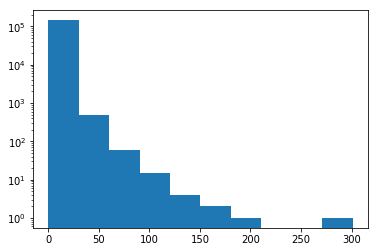

In [223]:
plt.hist(collision_join.collision_count, log=True)

# Statsmodel Linear Regression

In [275]:
model_OLS = sm.OLS(np.asarray(y), np.asarray(pd.get_dummies(x)))

In [276]:
res = model_OLS.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     185.8
Date:                Fri, 29 Jun 2018   Prob (F-statistic):               0.00
Time:                        12:20:18   Log-Likelihood:             1.7447e+05
No. Observations:              145338   AIC:                        -3.489e+05
Df Residuals:                  145319   BIC:                        -3.487e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0124      0.000    -39.883      0.000      -0.013      -0.012
x2             0.0039      0.000     11.947      0.000       0.003       0.005
x3            -0.0006   5.88e-05     -9.723      0.000      -0.001      -0.000
x4             0.0002   2.32e-05     10.321      0.000       0.000       0.000
x5             0.0018      0.001      1.355      0.175      -0.001       0.004
x6             0.0018      0.001      1.835      0.067      -0.000       0.004
x7             0.0041      0.001      3.137      0.002       0.002       0.007
x8             0.0021      0.001      1.758      0.079      -0.000       0.004
x9             0.0080      0.003      2.900      0.004       0.003       0.013
x10            0.0009      0.003      0.267      0.790      -0.006       0.007
x11            0.0009      0.008      0.121      0.904      -0.014       0.016
x12           -0.0075      0.002     -4.765      0.000      -0.011      -0.004
x13            0.0033      0.002      1.942      0.052   -3.03e-05       0.007
x14            0.0140      0.001     11.448      0.000       0.012       0.016
x15            0.0024      0.003      0.843      0.399      -0.003       0.008
x16            0.0013      0.003      0.461      0.645      -0.004       0.007
x17            0.0037      0.003      1.267      0.205      -0.002       0.009
x18           -0.0057      0.003     -1.970      0.049      -0.011   -3.01e-05
x19            0.0081      0.013      0.627      0.531      -0.017       0.033
x20            0.0024      0.002      1.253      0.210      -0.001       0.006
x21            0.0036      0.005      0.686      0.493      -0.007       0.014
x22            0.0024      0.002      1.259      0.208      -0.001       0.006
x23            0.0014      0.002      0.718      0.473      -0.002       0.005
==============================================================================
Omnibus:                   328135.333   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3256710038.808
Skew:                          21.428   Prob(JB):                         0.00
Kurtosis:                     735.087   Cond. No.                     2.09e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.79e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Trees

In [277]:
from sklearn.tree import DecisionTreeRegressor

In [278]:
clf = DecisionTreeRegressor()
clf = clf.fit(np.asarray(pd.get_dummies(x)), np.asarray(y))

In [279]:
clf.score(np.asarray(pd.get_dummies(x)), np.asarray(y))

0.11940812000341883

In [280]:
pd.get_dummies(x).columns

Index(['number_park_lanes', 'number_travel_lanes', 'posted_speed',
       'streetwidth_max', 'bike_trafdir_FT', 'bike_trafdir_No bike_trafdir',
       'bike_trafdir_TF', 'bike_trafdir_TW', 'featuretyp_0', 'featuretyp_6',
       'featuretyp_C', 'nonped_D', 'nonped_V', 'nonped_ped', 'snow_priority_C',
       'snow_priority_H', 'snow_priority_S', 'snow_priority_V',
       'snow_priority_no_priority', 'trafdir_A', 'trafdir_P', 'trafdir_T',
       'trafdir_W'],
      dtype='object')

Feature ranking:
1. feature number_park_lanes (0.370598)
2. feature number_travel_lanes (0.108308)
3. feature posted_speed (0.107699)
4. feature streetwidth_max (0.103707)
5. feature bike_trafdir_FT (0.055572)
6. feature bike_trafdir_No bike_trafdir (0.053163)
7. feature bike_trafdir_TF (0.033801)
8. feature bike_trafdir_TW (0.030246)
9. feature featuretyp_0 (0.028565)
10. feature featuretyp_6 (0.026865)
11. feature featuretyp_C (0.022420)
12. feature nonped_D (0.015294)
13. feature nonped_V (0.011964)
14. feature nonped_ped (0.010441)
15. feature snow_priority_C (0.008716)
16. feature snow_priority_H (0.008117)
17. feature snow_priority_S (0.002588)
18. feature snow_priority_V (0.000962)
19. feature snow_priority_no_priority (0.000638)
20. feature trafdir_A (0.000176)
21. feature trafdir_P (0.000095)
22. feature trafdir_T (0.000061)
23. feature trafdir_W (0.000005)


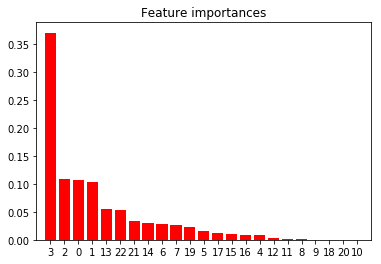

In [281]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(pd.get_dummies(x).shape[1]):
    print("%d. feature %s (%f)" % (f + 1, pd.get_dummies(x).columns[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(pd.get_dummies(x).shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(pd.get_dummies(x).shape[1]), indices)
plt.xlim([-1, pd.get_dummies(x).shape[1]])
plt.show()

# Downloading and uploading Waze Data

In [377]:
import requests
import re

api_key = 'api_key'
username = 'traffico-geographica'
download_file = 'nyc_waze_data_jams.csv'
q = "COPY nyc_waze_data_jams (blockingalert_uuid, city, country, date, delay, endnode, georss_date, length, level, roadtype, speed, startnode, street, the_geom, turntype, type, uuid) TO stdout WITH (FORMAT csv, HEADER true)"


# request the download, specifying desired file name
url = "http://%s.carto.com/api/v2/sql/copyto" % username
r = requests.get(url, params={'api_key': api_key, 'q': q, 'filename': download_file}, stream=True)
r.raise_for_status()

# read save file name from response headers
d = r.headers['content-disposition']
savefilename = re.findall("filename=(.+)", d)

if len(savefilename) > 0:
    with open(savefilename[0], 'wb') as handle:
        for block in r.iter_content(1024):
            handle.write(block)
    print("Downloaded to: %s" % savefilename)
else:
    print("Error: could not find read file name from headers")

KeyboardInterrupt: 

In [447]:
# Create table in account:

create_query = '''
CREATE TABLE nyc_waze_data_jams (
    blockingalert_uuid text,
    city text,
    country text,
    date timestamp,
    delay integer,
    endnode text, 
    georss_date timestamp,
    length real,
    level integer,
    roadtype integer,
    speed real,
    startnode text,
    street text,
    geometry text,
    turntype text,
    type text,
    uuid text
);

-- adds the 'cartodb_id' and 'the_geom_webmercator'
-- adds the required triggers and indexes
SELECT CDB_CartodbfyTable('michellemho-carto','nyc_waze_data_jams');

'''

In [448]:
cc = cartoframes.CartoContext(base_url='https://{username}.carto.com'.format(username='michellemho-carto'), api_key='29a2786e7462e8cdab49674be25159fce8939048')

In [449]:
cc.query(create_query)

,cdb_cartodbfytable
0,nyc_waze_data_jams


In [446]:
# Run only if you need to re-do the table creation!
# cc.query('DROP TABLE nyc_waze_data_jams')

""


In [450]:
# Upload to account
api_key = 'abcd'
username = 'michellemho-carto'
upload_file = 'nyc_waze_data_jams.csv'
q = '''COPY nyc_waze_data_jams (blockingalert_uuid,city,country,date,delay,endnode,georss_date,length,level,roadtype,speed,startnode,street,geometry,turntype,type,uuid) FROM STDIN WITH (FORMAT csv, HEADER true)'''

In [454]:
url = "http://%s.carto.com/api/v2/sql/copyfrom" % 'michellemho-carto'

In [456]:
import csv
from io import StringIO
import requests

def do_something(batch):
    r = requests.post(url, params={'api_key': api_key, 'q': q}, data=batch, stream=True)

    if r.status_code != 200:
        print(r.text)
    else:
        status = r.json()
        print("Success: %s rows imported" % status['total_rows'])

with open(upload_file, 'r') as csvfile:
    reader = csv.reader(csvfile)
    header = next(reader) # skip header

    batch_size = 50000
    batch = ''
    count = 0

    for row in reader:
        if count >= batch_size:
#             batch += '''"'''
#             print(batch)
            temp_stream = StringIO(batch)
            do_something(temp_stream)
            batch = ''
            count = 0
        batch +=  '\n' +'''"''' + '", "'.join(row) + '''"'''
        count += 1
    if batch:
        temp_stream = StringIO(batch)
        do_something(temp_stream)

Success: 50000 rows imported
Success: 50000 rows imported
Success: 10961 rows imported


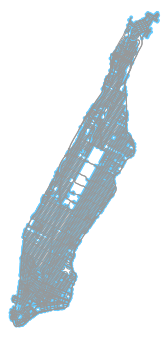

(<matplotlib.figure.Figure at 0x11c6bc748>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11c6bc1d0>)

In [57]:
import osmnx as ox
%matplotlib inline

G = ox.graph_from_place('Manhattan Island, New York City, New York, USA', network_type='drive')
ox.plot_graph(ox.project_graph(G))

In [58]:
nyc = ox.graph_from_place('New York City, New York, USA', network_type='drive')

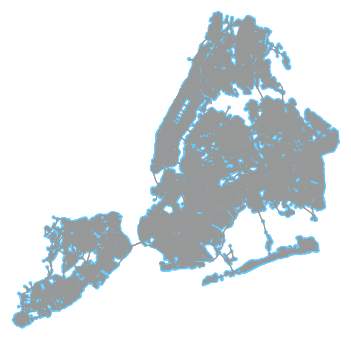

(<matplotlib.figure.Figure at 0x1a5c6849b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a5c6842b0>)

In [59]:
ox.plot_graph(ox.project_graph(nyc))

In [ ]:
nyc.

In [249]:
nypd_collisions = cc.read('collisions_geom')

In [261]:
nypd_collisions.dtypes

borough                                  object
contributing_factor_vehicle_1            object
contributing_factor_vehicle_2            object
contributing_factor_vehicle_3            object
contributing_factor_vehicle_4            object
contributing_factor_vehicle_5            object
cross_street_name                        object
date                             datetime64[ns]
latitude                                float64
location                                 object
longitude                               float64
number_of_cyclist_injured                 int64
number_of_cyclist_killed                  int64
number_of_motorist_injured                int64
number_of_motorist_killed                 int64
number_of_pedestrians_injured             int64
number_of_pedestrians_killed              int64
number_of_persons_injured                 int64
number_of_persons_killed                  int64
off_street_name                          object
on_street_name                          

In [270]:
nypd_collisions.zip_code.unique()

array([   nan, 11215., 10024., 10021., 11233., 11101., 10036., 11204.,
       11104., 11429., 11432., 10001., 11361., 11218., 11368., 10462.,
       10016., 10029., 10463., 11103., 11366., 10474., 11213., 10469.,
       11210., 11364., 11234., 11356., 11102., 10003., 10458., 11375.,
       10454., 10465., 10017., 11219., 10468., 11211., 10009., 11413.,
       10451., 11207., 10031., 10002., 11216., 11434., 11369., 11206.,
       10013., 10467., 10460., 11236., 10466., 11224., 11358., 10310.,
       10461., 11203., 11694., 10307., 11420., 10455., 11427., 10000.,
       11378., 10453., 10472., 11220., 10452., 11365., 10033., 11106.,
       10010., 11237., 11225., 11217., 10457., 11249., 11209., 10459.,
       11385., 10018., 11367., 11373., 11229., 10456., 10040., 10006.,
       11693., 11226., 10011., 11222., 11212., 10025., 10038., 11230.,
       11355., 11201., 11435., 11370., 11372., 10075., 11417., 10037.,
       10174., 11419., 10119., 10027., 10471., 11691., 11231., 10065.,
      

In [272]:
nypd_collisions.replace(to_replace='',value=np.NaN)

,borough,contributing_factor_vehicle_1,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,cross_street_name,date,latitude,location,...,on_street_name,the_geom,time,unique_key,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,zip_code
cartodb_id,,,,,,,,,,,,,,,,,,,,,
8084,NaN,Unspecified,NaN,NaN,NaN,NaN,NaN,2017-03-31,40.673588,"(40.673588, -73.96296)",...,SAINT JOHNS PLACE,0101000020E6100000CBD6FA22A17D52C0317DAF213856...,2018-06-28 21:15:00,3643833,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,NaN
3,NaN,Fell Asleep,NaN,NaN,NaN,NaN,NaN,2017-03-20,40.738495,"(40.738495, -73.90274)",...,NaN,0101000020E6100000A032FE7DC67952C038A11001875E...,2018-06-28 05:30:00,3635097,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,NaN
322,BROOKLYN,Unspecified,NaN,NaN,NaN,NaN,7 AVENUE,2017-03-20,40.658134,"(40.658134, -73.9896)",...,22 STREET,0101000020E6100000C8073D9B557F52C05D3123BC3D54...,2018-06-28 13:15:00,3635919,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,11215.0
405,NaN,Following Too Closely,Unspecified,NaN,NaN,NaN,NaN,2017-02-14,40.667800,"(40.6678, -73.801414)",...,NaN,0101000020E61000009E23F25D4A7352C068226C787A55...,2018-06-28 07:30:00,3616606,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,NaN
542,MANHATTAN,Unspecified,Unspecified,NaN,NaN,NaN,RIVERSIDE DRIVE,2017-03-20,40.792720,"(40.79272, -73.9771)",...,WEST 91 STREET,0101000020E6100000FB3A70CE887E52C04C7155D97765...,2018-06-28 14:00:00,3636189,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,10024.0
711,MANHATTAN,Unspecified,NaN,NaN,NaN,NaN,EAST 76 STREET,2017-03-20,40.774370,"(40.77437, -73.963554)",...,MADISON AVENUE,0101000020E6100000857B65DEAA7D52C07380608E1E63...,2018-06-28 12:30:00,3636806,NaN,NaN,NaN,NaN,NaN,10021.0
877,NaN,Unspecified,Unspecified,NaN,NaN,NaN,NaN,2017-03-31,40.695790,"(40.69579, -73.967804)",...,NaN,0101000020E6100000083C3080F07D52C022718FA50F59...,2018-06-28 10:24:00,3642456,NaN,NaN,NaN,NaN,NaN,NaN
881,BROOKLYN,Unspecified,NaN,NaN,NaN,NaN,NaN,2017-03-20,40.679962,"(40.679962, -73.91117)",...,NaN,0101000020E61000002AC6F99B507A52C0EA42ACFE0857...,2018-06-28 14:30:00,3637313,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,11233.0
1223,QUEENS,Unspecified,NaN,NaN,NaN,NaN,25 STREET,2017-03-21,40.740932,"(40.740932, -73.94485)",...,50 AVENUE,0101000020E61000000A68226C787C52C0AA471ADCD65E...,2018-06-28 13:45:00,3636626,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,11101.0
